# Imports

In [1]:
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import phoebe
from phoebe import u

import scienceplots
matplotlib.rcParams['figure.figsize'] = (16, 6)
plt.style.use('science')

import os
import sys
from pathlib import Path
baseModulePath = str(Path(os.getcwd()).parents[2].absolute())
if baseModulePath not in sys.path:
	sys.path.append(baseModulePath)

import importlib
import analisis.phoebe_model.utils as gen_utils
importlib.reload(gen_utils)

from analisis.phoebe_model.utils import printAllModelsChi2, printChi2

logger = phoebe.logger(clevel='WARNING')

# Load Bundle

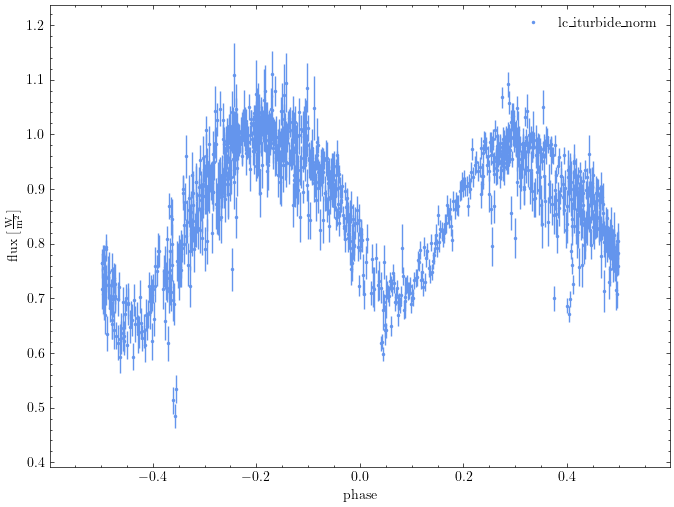

(<autofig.figure.Figure | 1 axes | 1 call(s)>,
 <Figure size 800x600 with 1 Axes>)

In [2]:
# b = phoebe.load("./bundle-saves/manual-periodogram")

# b = phoebe.load("./bundle-saves/clean-data/manual-periodogram")

# b = phoebe.load("./bundle-saves/aviles-data/manual-periodogram")
# b = phoebe.load("./bundle-saves/comp-LID3/manual-periodogram", import_from_newer=True)
# b = phoebe.load("../bundle-saves/iturbide-gaia-ztf")
# b = phoebe.load("../bundle-saves/relative-normalized/iturbide-gaia-ztf")
# gen_utils.resetAtmosphere(b)

# b = gen_utils.loadBundle(bundleName="manual-periodogram", subfolder="detached")
b = gen_utils.loadBundle(bundleName="contact-model", parentFolder="..")

IS_CONTACT = 'contact_envelope' in b.components

b.plot(x='phase', dataset='lc_iturbide_norm', show=True, legend=True, marker='.', c=gen_utils.ITURBIDE_PLOT_COLORS, s=0.008)

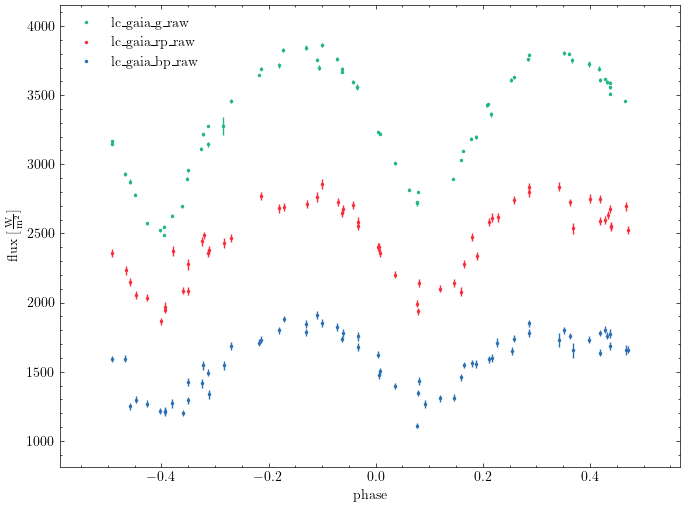

(<autofig.figure.Figure | 1 axes | 3 call(s)>,
 <Figure size 800x600 with 1 Axes>)

In [3]:
rawGaiaDatasets = [d for d in b.datasets if 'gaia' in d and 'raw' in d]

b.plot(x='phase', dataset=rawGaiaDatasets, color=gen_utils.GAIA_PLOT_COLORS, show=True, legend=True, marker='.', s=0.008)

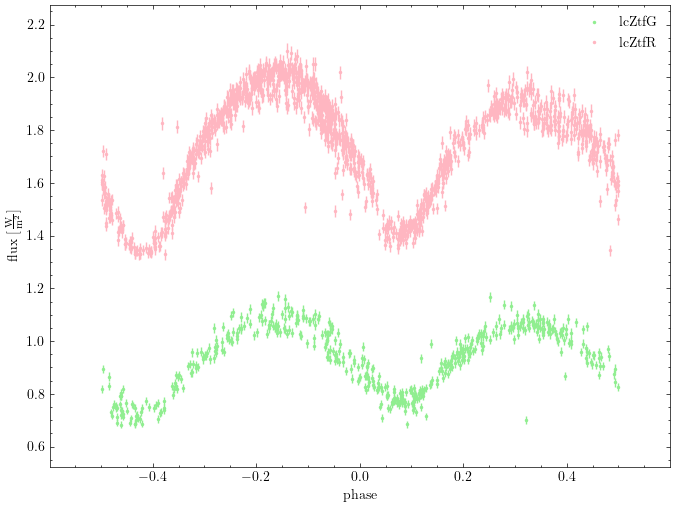

(<autofig.figure.Figure | 1 axes | 2 call(s)>,
 <Figure size 800x600 with 1 Axes>)

In [4]:
ztfDatasets = [d for d in b.datasets if 'Ztf' in d]

b.plot(x='phase', dataset=ztfDatasets, color=gen_utils.ZTF_PLOT_COLORS, show=True, legend=True, marker='.', s=0.008)

# Reducing compute time

Calculating forward model at only a fraction of the observed times to improve efficiency.

In [5]:
b.set_value_all(qualifier='compute_times', dataset=ztfDatasets, context='dataset', value=[])
b.flip_constraint('compute_phases@lcZtfG', solve_for='compute_times@lcZtfG')
b.flip_constraint('compute_phases@lcZtfR', solve_for='compute_times@lcZtfR')

# use same phases linspace for both ZTF datasets, so that model is only computed for one set of phase points
    # individual passband fluxes then integrated from passband files using same mesh, instead of using different compute times from individual datasets
b.set_value_all(qualifier='compute_phases', dataset=ztfDatasets, value=phoebe.linspace(-0.5, 0.5, num=151, endpoint=True))

In [6]:
iturbideTimes = b.get_value(qualifier='times', dataset='lc_iturbide_norm', context='dataset')

# need to keep it this way, otherwise not all phases are sampled properly
    # probably due to not uniform observations
b.set_value(qualifier='compute_times', dataset='lc_iturbide_norm', context='dataset', value=iturbideTimes[::6])

len(b.get_value(qualifier='compute_times', dataset='lc_iturbide_norm', context='dataset'))

165

In [7]:
# allGaiaTimes = np.concatenate(list(map(lambda gd: b.get_value(qualifier='times', dataset=gd, context='dataset'), rawGaiaDatasets)))
# b.set_value_all(qualifier='compute_times', dataset=rawGaiaDatasets, context='dataset', value=np.linspace(np.min(allGaiaTimes), np.max(allGaiaTimes), num=100, endpoint=True))

b.set_value_all(qualifier='compute_times', dataset=rawGaiaDatasets, context='dataset', value=[])
for gd in rawGaiaDatasets:
    b.flip_constraint(f"compute_phases@{gd}", solve_for=f"compute_times@{gd}")
b.set_value_all(qualifier='compute_phases', dataset=rawGaiaDatasets, context='dataset', value=phoebe.linspace(-0.5, 0.5, 81))

# Default forward models

In [8]:
# EBAI KNN values all seem to affect relative values
    # setting to dataset-scaled to see if at least general shape of model is correct
    # might also help with getting a good trend out of residuals when adopting estimator solutions
b.set_value_all(qualifier='pblum_mode', value='dataset-scaled')

In [9]:
if not IS_CONTACT:
    print("Avoiding atmosphere errors for semidetached model")
    gen_utils.avoidAtmosphereErrors(b) # parameters out of bounds by default when using CK2004 atmospheres, temporarily switching over to black body

b.run_compute(model='default_model', overwrite=True)

100%|██████████| 406/406 [00:25<00:00, 16.03it/s]


<ParameterSet: 231 parameters | kinds: lc, mesh>

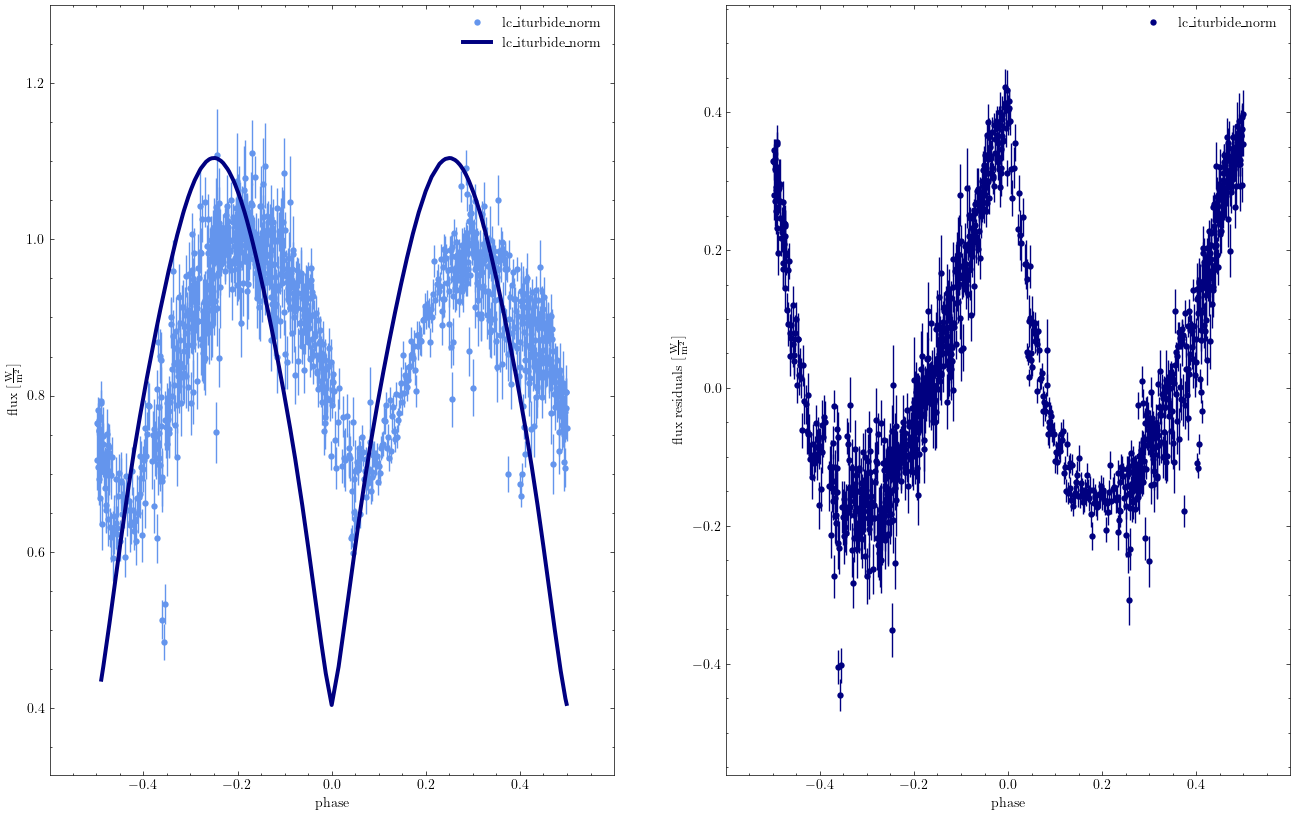

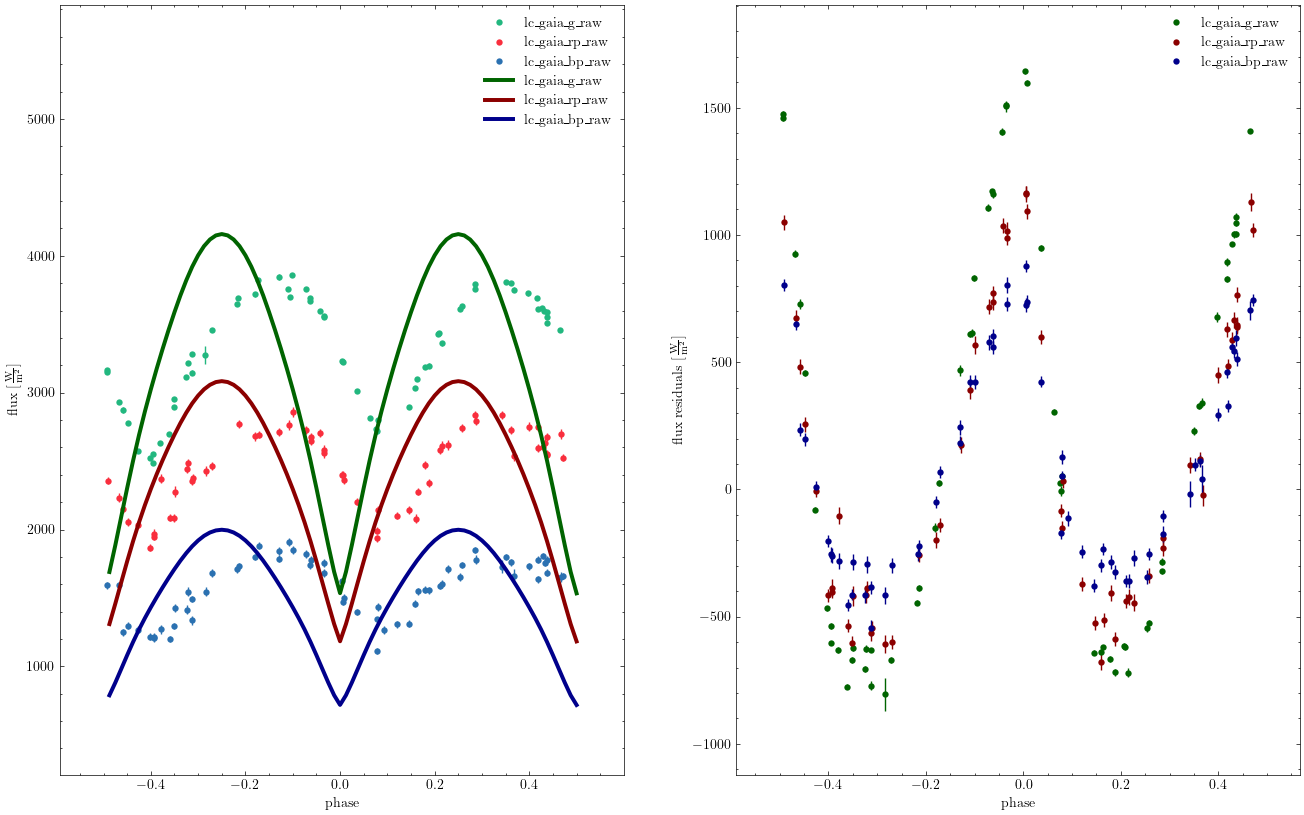

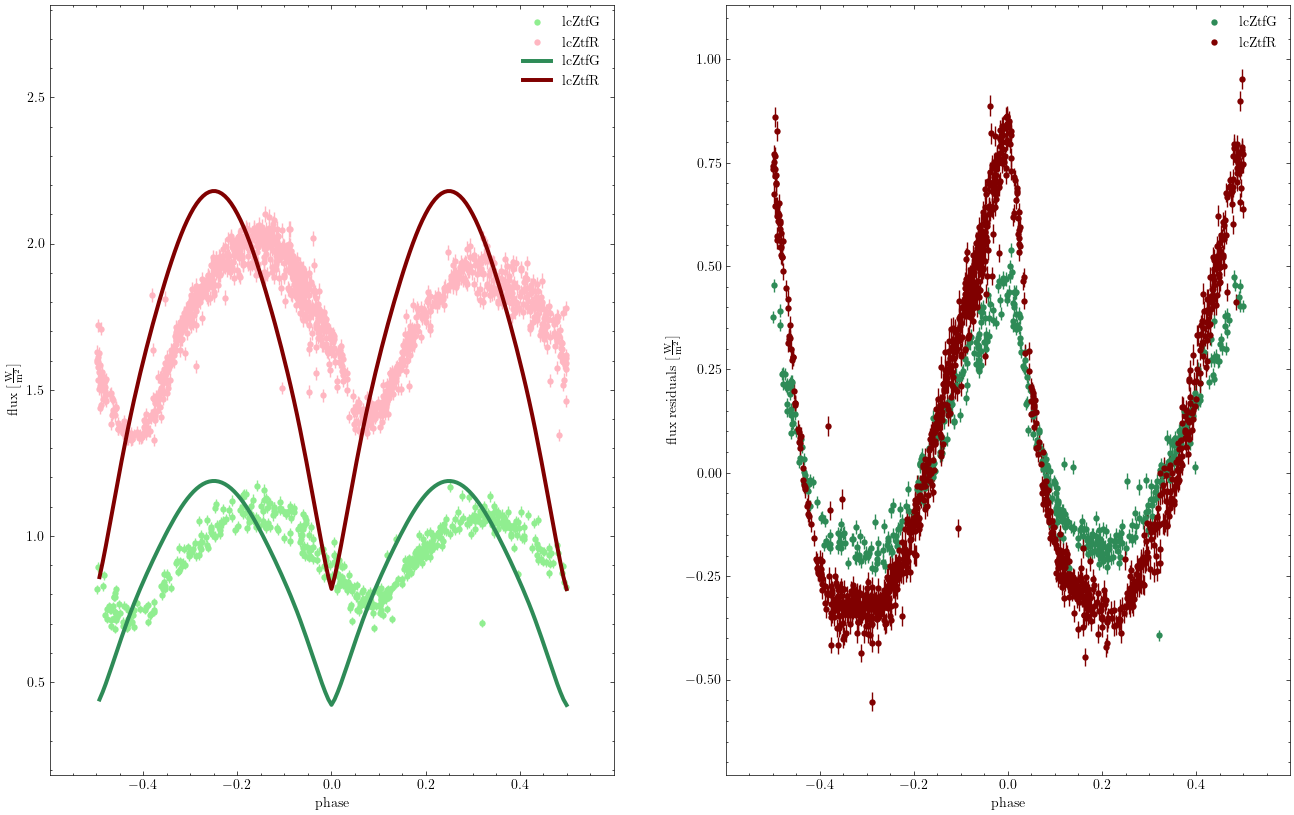

{'lc_iturbide_norm': <Figure size 1600x1000 with 2 Axes>,
 'lc_gaia_g_raw-lc_gaia_rp_raw-lc_gaia_bp_raw': <Figure size 1600x1000 with 2 Axes>,
 'lcZtfG-lcZtfR': <Figure size 1600x1000 with 2 Axes>}

In [10]:
gen_utils.plotModelResidualsFigsize(b, figsize=(16, 10), datasetGroups=[['lc_iturbide_norm'], rawGaiaDatasets, ztfDatasets], model='default_model')

# LC Geometry

Should only run if it's detached model

In [11]:
if not IS_CONTACT:
	b.add_solver('estimator.lc_geometry', solver='lcgeom_twogauss', analytical_model='two-gaussian', phase_bin=False, lc_datasets=['lc_iturbide_norm'] + rawGaiaDatasets + ztfDatasets, overwrite=True)
	b.run_solver(solver='lcgeom_twogauss', solution='lcgeom_twogauss_solution', overwrite=True)
	gen_utils.printFittedVals(b, 'lcgeom_twogauss_solution')
	print()
	gen_utils.printFittedTwigsConstraints(b, 'lcgeom_twogauss_solution')
else:
	print("Detected contact binary, can't run estimator.lcgeometry")

Detected contact binary, can't run estimator.lcgeometry


In [12]:
if not IS_CONTACT:
	b.add_solver('estimator.lc_geometry', solver='lcgeom_polyfit', analytical_model='polyfit', phase_bin=False, lc_datasets=['lc_iturbide_norm'] + rawGaiaDatasets + ztfDatasets, overwrite=True)
	b.run_solver(solver='lcgeom_polyfit', solution='lcgeom_polyfit_solution', overwrite=True)
	gen_utils.printFittedVals(b, 'lcgeom_polyfit_solution')
	print()
	gen_utils.printFittedTwigsConstraints(b, 'lcgeom_polyfit_solution')
else:
	print("Detected contact binary, can't run estimator.lcgeometry")

Detected contact binary, can't run estimator.lcgeometry


# EBAI KNN estimator runs

In [13]:
# ignore sklearn warnings; caused by PHOEBE internals
import warnings
warnings.filterwarnings("ignore", category=UserWarning)

# ebaiMethod = 'knn' if IS_CONTACT else 'mlp'
ebaiMethod = 'knn'

In [14]:
try:
	b.add_solver('estimator.ebai', ebai_method=ebaiMethod, phase_bin=False, solver=f'ebai_{ebaiMethod}_all', lc_datasets=['lc_iturbide_norm'] + rawGaiaDatasets + ztfDatasets, overwrite=True)
	print(b[f'ebai_{ebaiMethod}_all'])

	b.run_solver(solver=f'ebai_{ebaiMethod}_all', solution=f'ebai_{ebaiMethod}_all_solution', overwrite=True)
	gen_utils.printFittedVals(b, f'ebai_{ebaiMethod}_all_solution')
	print()
	gen_utils.printFittedTwigsConstraints(b, f'ebai_{ebaiMethod}_all_solution', {'incl@binary@orbit@component': u.rad})
except TypeError as e:
	print(e)

ParameterSet: 7 parameters
     comments@ebai_knn_all@solver: 
   use_server@ebai_knn_all@solver: none
   lc_datasets@ebai_knn_all@so...: ['lc_iturbide_norm', 'lc_gaia_g_raw', 'lc_gaia_rp_raw', 'lc_gaia_bp_raw', 'lcZtfG', 'lcZtfR']
   lc_combine@ebai_knn_all@solver: median
    phase_bin@ebai_knn_all@solver: False
   ebai_method@ebai_knn_all@so...: knn
        orbit@ebai_knn_all@solver: binary


Wed, 24 Jul 2024 15:42 PHOEBE       WARNING checks will not be run until 'run_checks' or 'run_compute' is called.
Wed, 24 Jul 2024 15:42 PHOEBE       WARNING constraints will not be run until 'run_delayed_constraints' or 'run_compute' is called.  This may result in inconsistent parameters if printing values before calling either of these methods.


t0_supconj@binary@orbit@component -0.11906 d 
teffratio@binary@orbit@component 0.94282  
incl@binary@orbit@component 1.50888 rad 
fillout_factor@contact_envelope@envelope@component 0.64545  
q@binary@orbit@component 9.06676  

  t0_supconj@binary@orbit@component 0.00000 d 
C teffratio@binary@orbit@component 1.00000 
  incl@binary@orbit@component 1.57080 rad 
C fillout_factor@contact_envelope@envelope@component 0.64179 
  q@binary@orbit@component 1.00000 


In [15]:
b.add_solver('estimator.ebai', ebai_method=ebaiMethod, phase_bin=False, solver=f'ebai_{ebaiMethod}_ztf_gaia', lc_datasets=rawGaiaDatasets + ztfDatasets, overwrite=True)
print(b['ebai_knn_ztf_gaia'])

b.run_solver(solver=f'ebai_{ebaiMethod}_ztf_gaia', solution=f'ebai_{ebaiMethod}_ztf_gaia_solution', overwrite=True)
gen_utils.printFittedVals(b, f'ebai_{ebaiMethod}_ztf_gaia_solution', units={'incl@binary@orbit@component': u.deg})
print()
gen_utils.printFittedTwigsConstraints(b, f'ebai_{ebaiMethod}_ztf_gaia_solution', {'incl@binary@orbit@component': u.deg})

ParameterSet: 7 parameters
   comments@ebai_knn_ztf_gaia@...: 
   use_server@ebai_knn_ztf_gai...: none
   lc_datasets@ebai_knn_ztf_ga...: ['lc_gaia_g_raw', 'lc_gaia_rp_raw', 'lc_gaia_bp_raw', 'lcZtfG', 'lcZtfR']
   lc_combine@ebai_knn_ztf_gai...: median
   phase_bin@ebai_knn_ztf_gaia...: False
   ebai_method@ebai_knn_ztf_ga...: knn
   orbit@ebai_knn_ztf_gaia@solver: binary
t0_supconj@binary@orbit@component 0.02571 d 
teffratio@binary@orbit@component 0.98746  
incl@binary@orbit@component 70.31953 deg 
fillout_factor@contact_envelope@envelope@component 0.25767  
q@binary@orbit@component 1.93380  

  t0_supconj@binary@orbit@component 0.00000 d 
C teffratio@binary@orbit@component 1.00000 
  incl@binary@orbit@component 90.00000 deg 
C fillout_factor@contact_envelope@envelope@component 0.64179 
  q@binary@orbit@component 1.00000 


In [16]:
try:
	b.add_solver('estimator.ebai', ebai_method=ebaiMethod, phase_bin=False, solver=f'ebai_{ebaiMethod}_iturbide', lc_datasets=['lc_iturbide_norm'], overwrite=True)
	print(b[f'ebai_{ebaiMethod}_iturbide'])

	b.run_solver(solver=f'ebai_{ebaiMethod}_iturbide', solution=f'ebai_{ebaiMethod}_iturbide_solution', overwrite=True)
	gen_utils.printFittedVals(b, f'ebai_{ebaiMethod}_iturbide_solution', units={'incl@binary@orbit@component': u.deg})
	print()
	gen_utils.printFittedTwigsConstraints(b, f'ebai_{ebaiMethod}_iturbide_solution', {'incl@binary@orbit@component': u.deg})
except TypeError as e:
	print(e)

ParameterSet: 6 parameters
   comments@ebai_knn_iturbide@...: 
   use_server@ebai_knn_iturbid...: none
   lc_datasets@ebai_knn_iturbi...: ['lc_iturbide_norm']
   phase_bin@ebai_knn_iturbide...: False
   ebai_method@ebai_knn_iturbi...: knn
   orbit@ebai_knn_iturbide@solver: binary
t0_supconj@binary@orbit@component 0.01491 d 
teffratio@binary@orbit@component 0.99739  
incl@binary@orbit@component 72.81121 deg 
fillout_factor@contact_envelope@envelope@component 0.90865  
q@binary@orbit@component 5.37843  

  t0_supconj@binary@orbit@component 0.00000 d 
C teffratio@binary@orbit@component 1.00000 
  incl@binary@orbit@component 90.00000 deg 
C fillout_factor@contact_envelope@envelope@component 0.64179 
  q@binary@orbit@component 1.00000 


In [17]:
b.add_solver('estimator.ebai', ebai_method=ebaiMethod, phase_bin=False, solver=f'ebai_{ebaiMethod}_iturbide_ztf', lc_datasets=['lc_iturbide_norm'] + ztfDatasets, overwrite=True)
print(b[f'ebai_{ebaiMethod}_iturbide_ztf'])

b.run_solver(solver=f'ebai_{ebaiMethod}_iturbide_ztf', solution=f'ebai_{ebaiMethod}_iturbide_ztf_solution', overwrite=True)
gen_utils.printFittedVals(b, f'ebai_{ebaiMethod}_iturbide_ztf_solution')
print()
gen_utils.printFittedTwigsConstraints(b, f'ebai_{ebaiMethod}_iturbide_ztf_solution', {'incl@binary@orbit@component': u.rad})

ParameterSet: 7 parameters
   comments@ebai_knn_iturbide_...: 
   use_server@ebai_knn_iturbid...: none
   lc_datasets@ebai_knn_iturbi...: ['lc_iturbide_norm', 'lcZtfG', 'lcZtfR']
   lc_combine@ebai_knn_iturbid...: median
   phase_bin@ebai_knn_iturbide...: False
   ebai_method@ebai_knn_iturbi...: knn
   orbit@ebai_knn_iturbide_ztf...: binary
t0_supconj@binary@orbit@component -0.11906 d 
teffratio@binary@orbit@component 0.95861  
incl@binary@orbit@component 1.41320 rad 
fillout_factor@contact_envelope@envelope@component 0.80277  
q@binary@orbit@component 9.59086  

  t0_supconj@binary@orbit@component 0.00000 d 
C teffratio@binary@orbit@component 1.00000 
  incl@binary@orbit@component 1.57080 rad 
C fillout_factor@contact_envelope@envelope@component 0.64179 
  q@binary@orbit@component 1.00000 


In [18]:
b.add_solver('estimator.ebai', ebai_method=ebaiMethod, phase_bin=False, solver=f'ebai_{ebaiMethod}_ztf', lc_datasets=ztfDatasets, overwrite=True)
try:
	b.run_solver(solver=f'ebai_{ebaiMethod}_ztf', solution=f'ebai_{ebaiMethod}_ztf_solution', overwrite=True)
	gen_utils.printFittedVals(b, f'ebai_{ebaiMethod}_ztf_solution')
	print()
	gen_utils.printFittedTwigsConstraints(b, f'ebai_{ebaiMethod}_ztf_solution', {'incl@binary': u.rad})
except TypeError as e:
	print("Failed to generate estimation for normalized Gaia data", e, sep='\n')

t0_supconj@binary@orbit@component 0.03040 d 
teffratio@binary@orbit@component 0.99635  
incl@binary@orbit@component 1.27098 rad 
fillout_factor@contact_envelope@envelope@component 0.56954  
q@binary@orbit@component 5.44866  

  t0_supconj@binary@orbit@component 0.00000 d 
C teffratio@binary@orbit@component 1.00000 
  incl@binary@orbit@component 90.00000 deg 
C fillout_factor@contact_envelope@envelope@component 0.64179 
  q@binary@orbit@component 1.00000 


In [19]:
b.add_solver('estimator.ebai', ebai_method=ebaiMethod, phase_bin=False, solver=f'ebai_{ebaiMethod}_raw_gaia', lc_datasets=rawGaiaDatasets, overwrite=True)
b.run_solver(solver=f'ebai_{ebaiMethod}_raw_gaia', solution=f'ebai_{ebaiMethod}_raw_gaia_solution', overwrite=True)
gen_utils.printFittedVals(b, f'ebai_{ebaiMethod}_raw_gaia_solution')
print()
gen_utils.printFittedTwigsConstraints(b, f'ebai_{ebaiMethod}_raw_gaia_solution', {'incl@binary': u.rad})

t0_supconj@binary@orbit@component 0.02571 d 
teffratio@binary@orbit@component 0.98753  
incl@binary@orbit@component 1.25892 rad 
fillout_factor@contact_envelope@envelope@component 0.16514  
q@binary@orbit@component 2.46108  

  t0_supconj@binary@orbit@component 0.00000 d 
C teffratio@binary@orbit@component 1.00000 
  incl@binary@orbit@component 90.00000 deg 
C fillout_factor@contact_envelope@envelope@component 0.64179 
  q@binary@orbit@component 1.00000 


In [20]:
print(b['teffratio'])
print(b['fillout_factor']) # only appears for contact binary
print(b['teff'])

ParameterSet: 2 parameters
C      teffratio@binary@component: 1.0
             teffratio@constraint: {teff@secondary@component} / {teff@primary@component}
ParameterSet: 2 parameters
C  fillout_factor@contact_enve...: 0.6417897080770943
        fillout_factor@constraint: pot_to_fillout_factor({q@binary@component}, {pot@contact_envelope@component})
ParameterSet: 3 parameters
           teff@primary@component: 6000.0 K
         teff@secondary@component: 6000.0 K
   teff@poro_porb_bounds@distr...: <distl.uniform low=5663.281417764556 high=5826.300406111852 unit=K label=teff@primary label_latex=$T_{ \mathrm{ eff }, \mathrm{ primary } }$>


## Flip constraints

In [21]:
gen_utils.printFittedTwigsConstraints(b, f'ebai_{ebaiMethod}_raw_gaia_solution', {'incl@binary': u.rad})

  t0_supconj@binary@orbit@component 0.00000 d 
C teffratio@binary@orbit@component 1.00000 
  incl@binary@orbit@component 90.00000 deg 
C fillout_factor@contact_envelope@envelope@component 0.64179 
  q@binary@orbit@component 1.00000 


In [22]:
print(b['fillout_factor'])
print(b['pot'])

ParameterSet: 2 parameters
C  fillout_factor@contact_enve...: 0.6417897080770943
        fillout_factor@constraint: pot_to_fillout_factor({q@binary@component}, {pot@contact_envelope@component})
ParameterSet: 2 parameters
C  pot@contact_envelope@component: 3.401377407229877
                   pot@constraint: requiv_to_pot_contact({requiv@primary@component}, {q@binary@component}, {sma@binary@component}, 1)


In [22]:
b.flip_constraint('teffratio', solve_for='teff@secondary')
if IS_CONTACT:
	b.flip_constraint('pot@contact_envelope', solve_for='requiv@primary')
	b.flip_constraint('fillout_factor', solve_for='pot@contact_envelope')
else:
	b.flip_constraint('sma@binary', solve_for='q')
	b.flip_constraint('requivsumfrac', solve_for='sma@binary')

## Checking solution goodness of fit

In [23]:
b.set_value_all(qualifier='enabled', value=True)

print(b['enabled'])

ParameterSet: 7 parameters
   enabled@mesh01@phoebe01@com...: True
   enabled@lc_iturbide_norm@ph...: True
   enabled@lc_gaia_g_raw@phoeb...: True
   enabled@lc_gaia_rp_raw@phoe...: True
   enabled@lc_gaia_bp_raw@phoe...: True
   enabled@lcZtfG@phoebe01@com...: True
   enabled@lcZtfR@phoebe01@com...: True


In [24]:
print(b['requiv'])
print(b['sma@binary'])
print(b['mass'])
print(b['q'])
print(b['ntriangles'])

ParameterSet: 4 parameters
C        requiv@primary@component: 1.4999999999999998 solRad
C      requiv@secondary@component: 1.4999999999999996 solRad
        requiv@primary@constraint: pot_to_requiv_contact({pot@contact_envelope@component}, {q@binary@component}, {sma@binary@component}, 1)
      requiv@secondary@constraint: pot_to_requiv_contact({pot@contact_envelope@component}, {q@binary@component}, {sma@binary@component}, 2)
ParameterSet: 2 parameters
C            sma@binary@component: 3.3499999999999996 solRad
            sma@binary@constraint: (((({mass@primary@component} * ({period@binary@component} ** 2.000000)) * ({q@binary@component} + 1.000000)) * 2942.206217504419328179210424423218) / 39.478418) ** (1./3)
ParameterSet: 4 parameters
           mass@primary@component: 2.26687409889228 solMass
C        mass@secondary@component: 2.26687409889228 solMass
                  mass@constraint: (39.478418 * ({sma@binary@component} ** 3.000000)) / ((({period@binary@component} ** 2.000000) 

In [25]:
if IS_CONTACT:
	b.set_value(qualifier='ntriangles', value=5000) # originally 3000
	print(b['ntriangles'])

Parameter: ntriangles@contact_envelope@phoebe01@compute
                       Qualifier: ntriangles
                     Description: Requested number of triangles (won't be exact).
                           Value: 5000
                  Constrained by: 
                      Constrains: None
                      Related to: None
                 Only visible if: mesh_method:marching,hierarchy.is_meshable:true



lcgeom_twogauss_solution not found
lcgeom_polyfit_solution not found
ebai_knn_all_solution | ebai_knn_all_model
------------------------------------------------
Adopted:
t0_supconj@binary@orbit@component -0.11906 d 
teffratio@binary@orbit@component 0.94282  
incl@binary@orbit@component 1.50888 rad 
fillout_factor@contact_envelope@envelope@component 0.64545  
q@binary@orbit@component 9.06676  

Original values:
  t0_supconj@binary@orbit@component 0.00000 d 
  teffratio@binary@orbit@component 1.00000 
  incl@binary@orbit@component 90.00000 deg 
  fillout_factor@contact_envelope@envelope@component 0.64179 
  q@binary@orbit@component 1.00000 


100%|██████████| 407/407 [00:51<00:00,  7.86it/s]
Fri, 19 Jul 2024 14:32 BUNDLE       ERROR   Constraint 'requiv@secondary@star@constraint' raised the following error while attempting to solve for 'requiv@secondary@star@component'.  Consider flipping the constraint or changing the value of one of ['pot@contact_envelope@envelope@component', 'q@binary@orbit@component', 'sma@binary@orbit@component', 'requiv@secondary@star@component'] until the constraint succeeds.  Original error: potential > L1 critical value
Fri, 19 Jul 2024 14:32 BUNDLE       ERROR   Constraint 'requiv@primary@star@constraint' raised the following error while attempting to solve for 'requiv@primary@star@component'.  Consider flipping the constraint or changing the value of one of ['requiv@primary@star@component', 'q@binary@orbit@component', 'sma@binary@orbit@component', 'pot@contact_envelope@envelope@component'] until the constraint succeeds.  Original error: potential > L1 critical value


ebai_knn_all_model
	 Gaia (Raw) - 40822.40374327645
		 lc_gaia_g_raw - 36744.16642909285
		 lc_gaia_rp_raw - 2549.20479279524
		 lc_gaia_bp_raw - 1529.0325213883627
------------------------------------------------
	 ZTF - 79979.63676248693
		 lcZtfG - 19971.774483794503
		 lcZtfR - 60007.862278692424


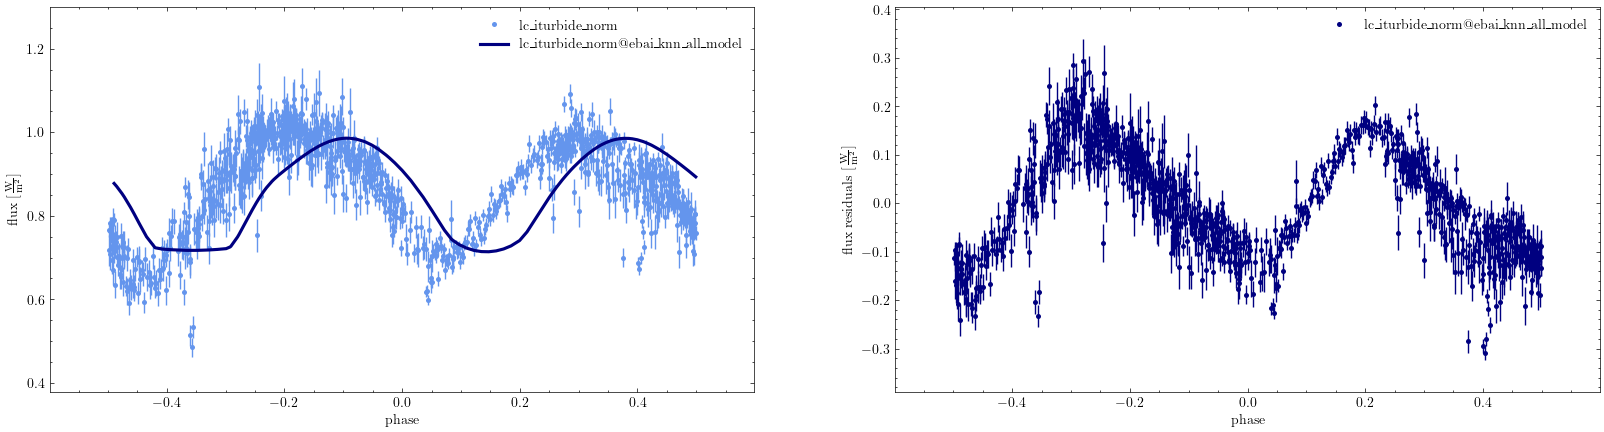

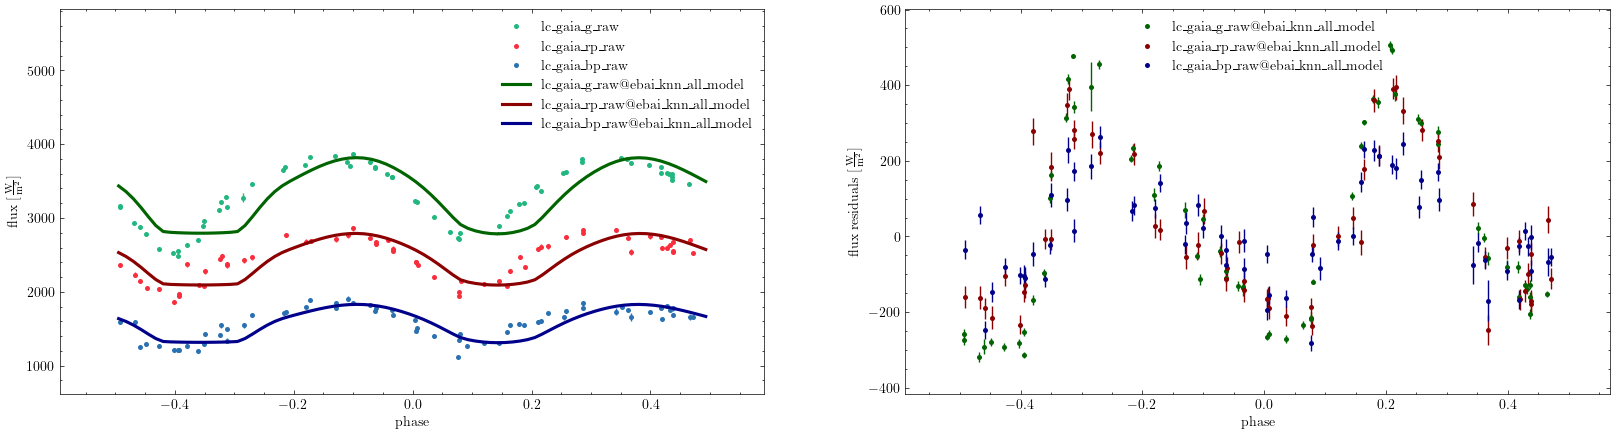

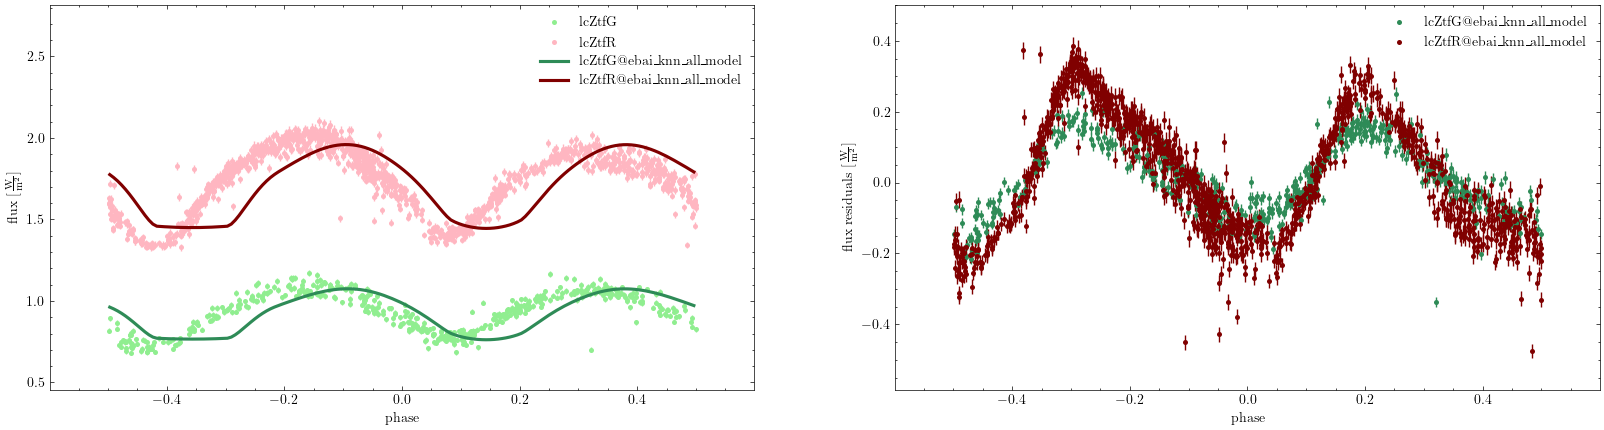

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

GridspecLayout(children=(HTML(value='<video width="800" height="600" controls autoplay loop>\n  <source type="…

ebai_knn_ztf_gaia_solution | ebai_knn_ztf_gaia_model
------------------------------------------------
Adopted:
t0_supconj@binary@orbit@component 0.02571 d 
teffratio@binary@orbit@component 0.98746  
incl@binary@orbit@component 1.22731 rad 
fillout_factor@contact_envelope@envelope@component 0.25767  
q@binary@orbit@component 1.93380  

Original values:
  t0_supconj@binary@orbit@component 0.00000 d 
  teffratio@binary@orbit@component 1.00000 
  incl@binary@orbit@component 90.00000 deg 
  fillout_factor@contact_envelope@envelope@component 0.64179 
  q@binary@orbit@component 1.00000 


100%|██████████| 407/407 [01:31<00:00,  4.47it/s]
Fri, 19 Jul 2024 14:35 BUNDLE       ERROR   Constraint 'requiv@secondary@star@constraint' raised the following error while attempting to solve for 'requiv@secondary@star@component'.  Consider flipping the constraint or changing the value of one of ['pot@contact_envelope@envelope@component', 'q@binary@orbit@component', 'sma@binary@orbit@component', 'requiv@secondary@star@component'] until the constraint succeeds.  Original error: potential > L1 critical value
Fri, 19 Jul 2024 14:35 BUNDLE       ERROR   Constraint 'requiv@primary@star@constraint' raised the following error while attempting to solve for 'requiv@primary@star@component'.  Consider flipping the constraint or changing the value of one of ['requiv@primary@star@component', 'q@binary@orbit@component', 'sma@binary@orbit@component', 'pot@contact_envelope@envelope@component'] until the constraint succeeds.  Original error: potential > L1 critical value


ebai_knn_ztf_gaia_model
	 Gaia (Raw) - 13179.391960499164
		 lc_gaia_g_raw - 11176.214138242252
		 lc_gaia_rp_raw - 996.3525413500265
		 lc_gaia_bp_raw - 1006.8252809068861
------------------------------------------------
	 ZTF - 16149.418628296586
		 lcZtfG - 5244.70975577262
		 lcZtfR - 10904.708872523966


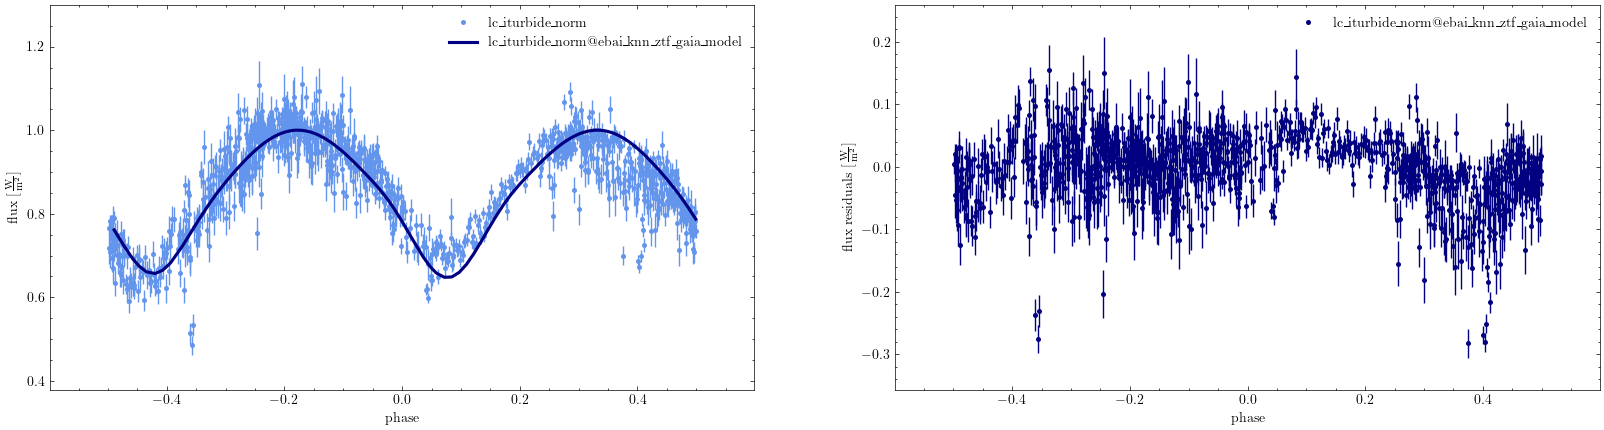

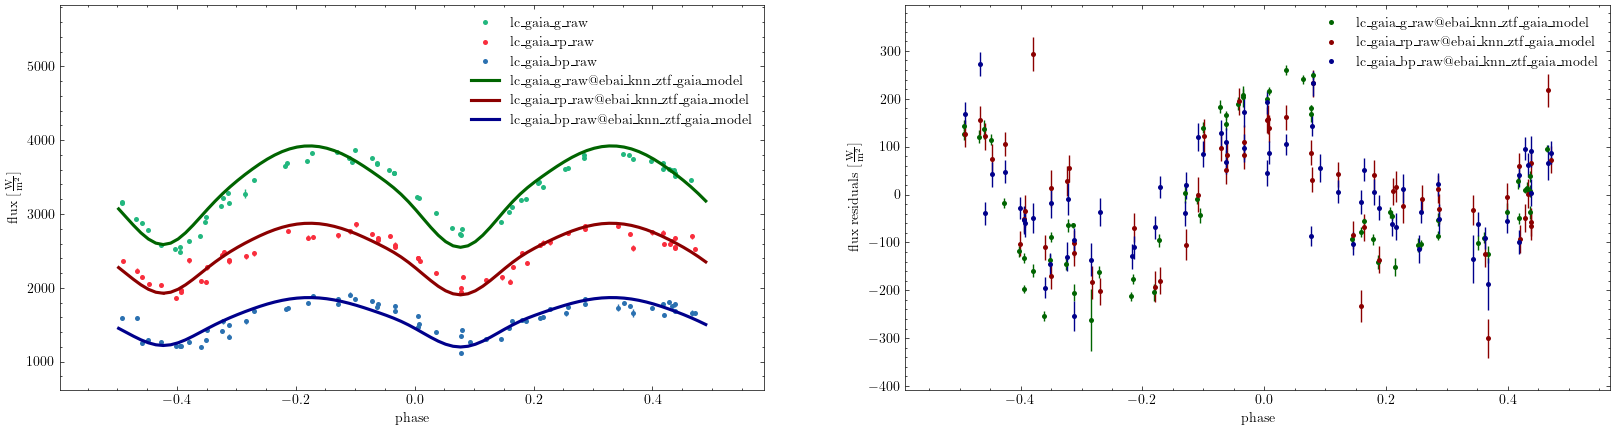

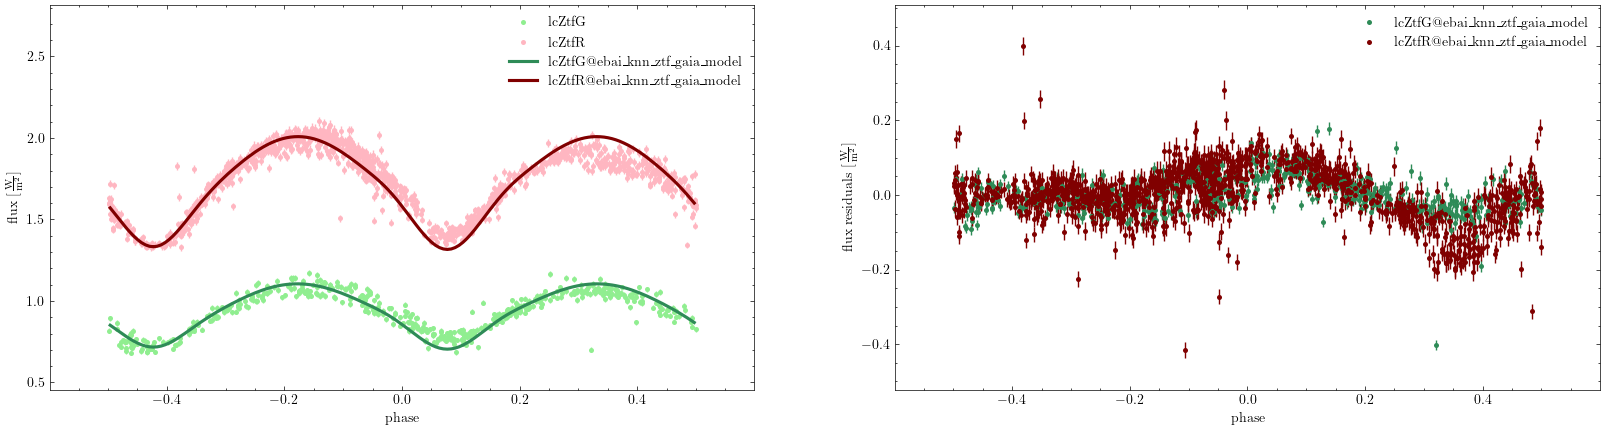

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

GridspecLayout(children=(HTML(value='<video width="800" height="600" controls autoplay loop>\n  <source type="…

ebai_knn_iturbide_solution | ebai_knn_iturbide_model
------------------------------------------------
Adopted:
t0_supconj@binary@orbit@component 0.01491 d 
teffratio@binary@orbit@component 0.99739  
incl@binary@orbit@component 1.27080 rad 
fillout_factor@contact_envelope@envelope@component 0.90865  
q@binary@orbit@component 5.37843  

Original values:
  t0_supconj@binary@orbit@component 0.00000 d 
  teffratio@binary@orbit@component 1.00000 
  incl@binary@orbit@component 90.00000 deg 
  fillout_factor@contact_envelope@envelope@component 0.64179 
  q@binary@orbit@component 1.00000 


100%|██████████| 407/407 [01:00<00:00,  6.70it/s]
Fri, 19 Jul 2024 14:38 BUNDLE       ERROR   Constraint 'requiv@secondary@star@constraint' raised the following error while attempting to solve for 'requiv@secondary@star@component'.  Consider flipping the constraint or changing the value of one of ['pot@contact_envelope@envelope@component', 'q@binary@orbit@component', 'sma@binary@orbit@component', 'requiv@secondary@star@component'] until the constraint succeeds.  Original error: potential > L1 critical value
Fri, 19 Jul 2024 14:38 BUNDLE       ERROR   Constraint 'requiv@primary@star@constraint' raised the following error while attempting to solve for 'requiv@primary@star@component'.  Consider flipping the constraint or changing the value of one of ['requiv@primary@star@component', 'q@binary@orbit@component', 'sma@binary@orbit@component', 'pot@contact_envelope@envelope@component'] until the constraint succeeds.  Original error: potential > L1 critical value


ebai_knn_iturbide_model
	 Gaia (Raw) - 53166.17501017961
		 lc_gaia_g_raw - 47101.63876232215
		 lc_gaia_rp_raw - 3275.106440787009
		 lc_gaia_bp_raw - 2789.4298070704513
------------------------------------------------
	 ZTF - 40615.384628123924
		 lcZtfG - 8975.046949134983
		 lcZtfR - 31640.337678988944


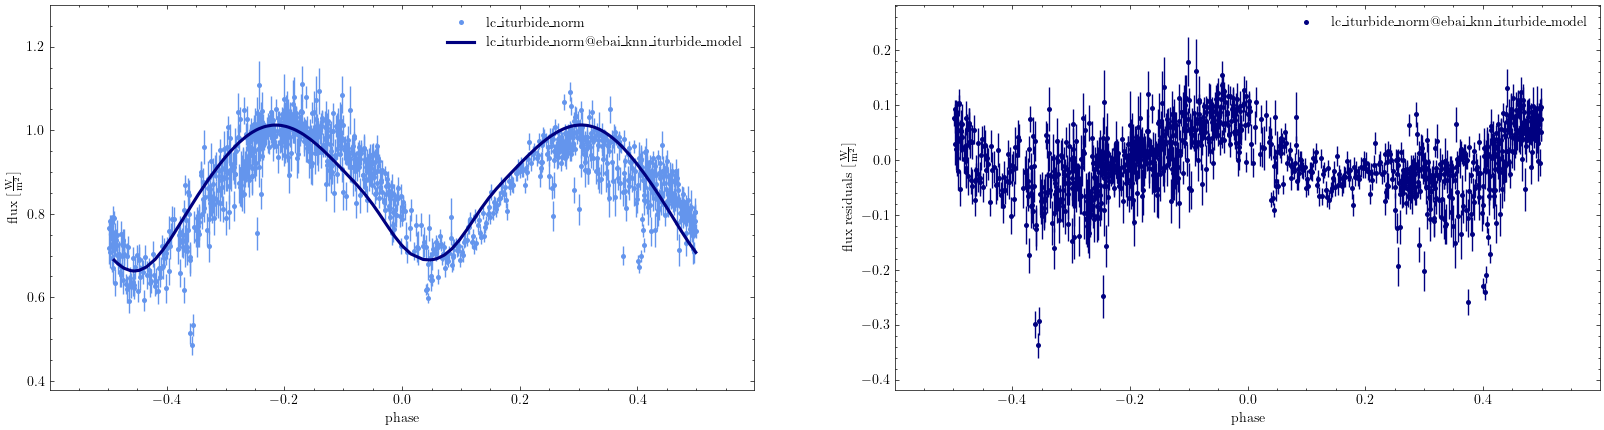

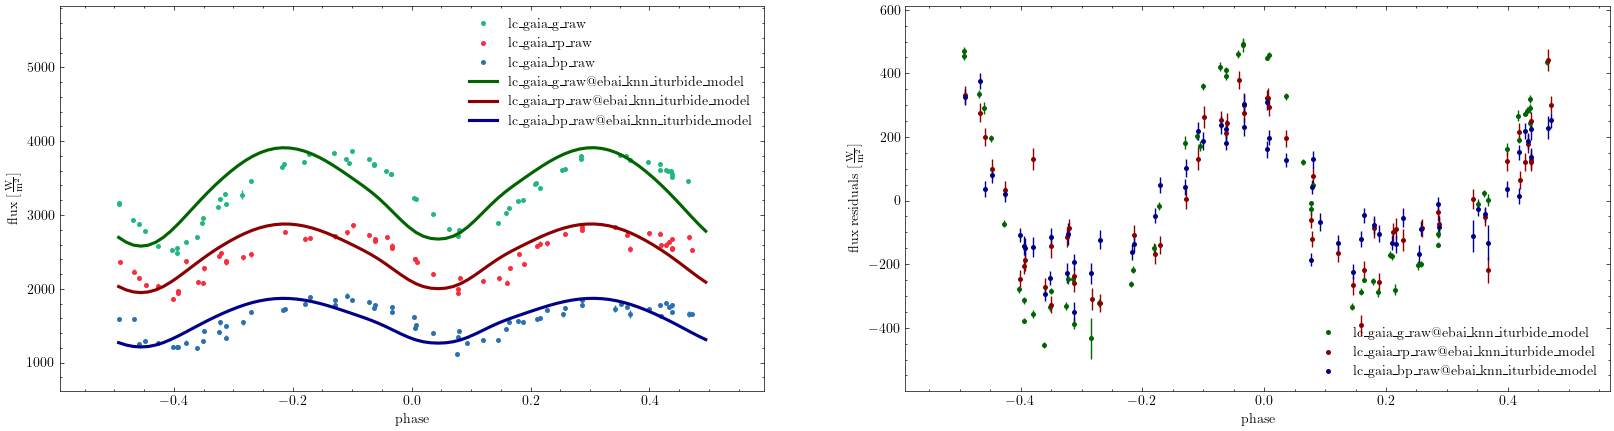

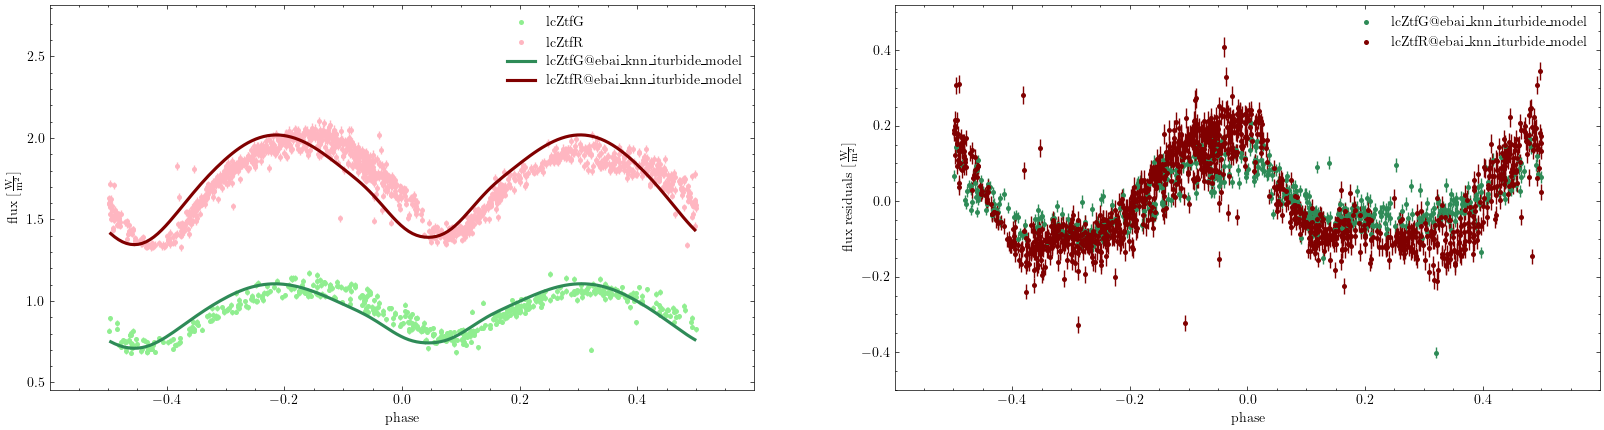

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

GridspecLayout(children=(HTML(value='<video width="800" height="600" controls autoplay loop>\n  <source type="…

ebai_knn_iturbide_ztf_solution | ebai_knn_iturbide_ztf_model
------------------------------------------------
Adopted:
t0_supconj@binary@orbit@component -0.11906 d 
teffratio@binary@orbit@component 0.95861  
incl@binary@orbit@component 1.41320 rad 
fillout_factor@contact_envelope@envelope@component 0.80277  
q@binary@orbit@component 9.59086  

Original values:
  t0_supconj@binary@orbit@component 0.00000 d 
  teffratio@binary@orbit@component 1.00000 
  incl@binary@orbit@component 90.00000 deg 
  fillout_factor@contact_envelope@envelope@component 0.64179 
  q@binary@orbit@component 1.00000 


100%|██████████| 407/407 [00:51<00:00,  7.84it/s]
Fri, 19 Jul 2024 14:41 BUNDLE       ERROR   Constraint 'requiv@secondary@star@constraint' raised the following error while attempting to solve for 'requiv@secondary@star@component'.  Consider flipping the constraint or changing the value of one of ['pot@contact_envelope@envelope@component', 'q@binary@orbit@component', 'sma@binary@orbit@component', 'requiv@secondary@star@component'] until the constraint succeeds.  Original error: potential > L1 critical value
Fri, 19 Jul 2024 14:41 BUNDLE       ERROR   Constraint 'requiv@primary@star@constraint' raised the following error while attempting to solve for 'requiv@primary@star@component'.  Consider flipping the constraint or changing the value of one of ['requiv@primary@star@component', 'q@binary@orbit@component', 'sma@binary@orbit@component', 'pot@contact_envelope@envelope@component'] until the constraint succeeds.  Original error: potential > L1 critical value


ebai_knn_iturbide_ztf_model
	 Gaia (Raw) - 40207.035270424145
		 lc_gaia_g_raw - 36180.03962309817
		 lc_gaia_rp_raw - 2488.582137843128
		 lc_gaia_bp_raw - 1538.4135094828434
------------------------------------------------
	 ZTF - 77053.93554906
		 lcZtfG - 19614.713984337664
		 lcZtfR - 57439.221564722335


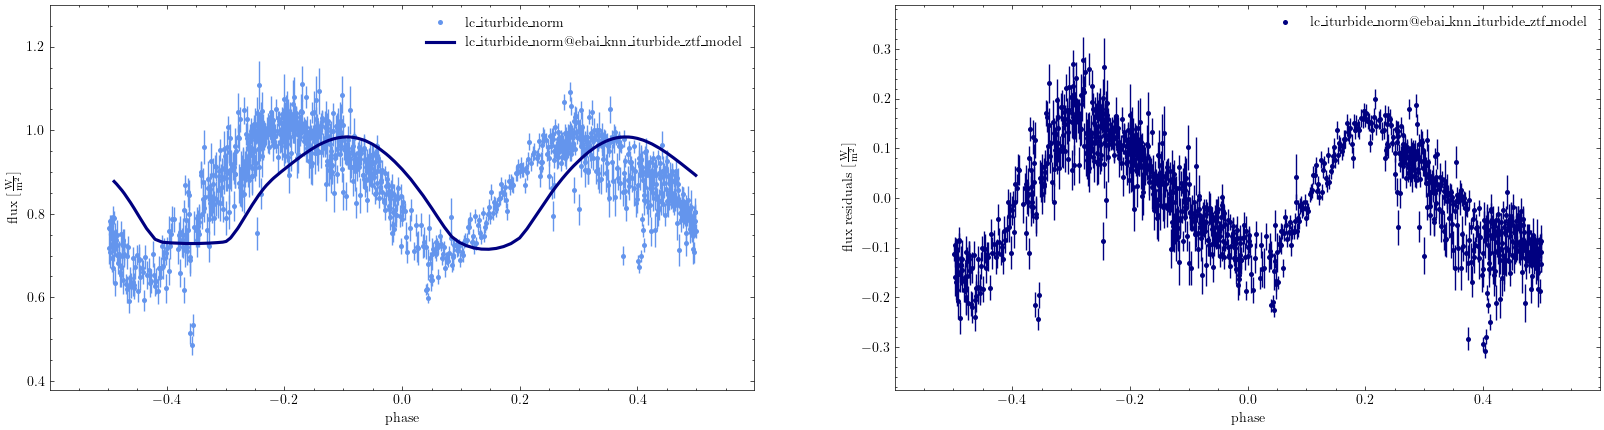

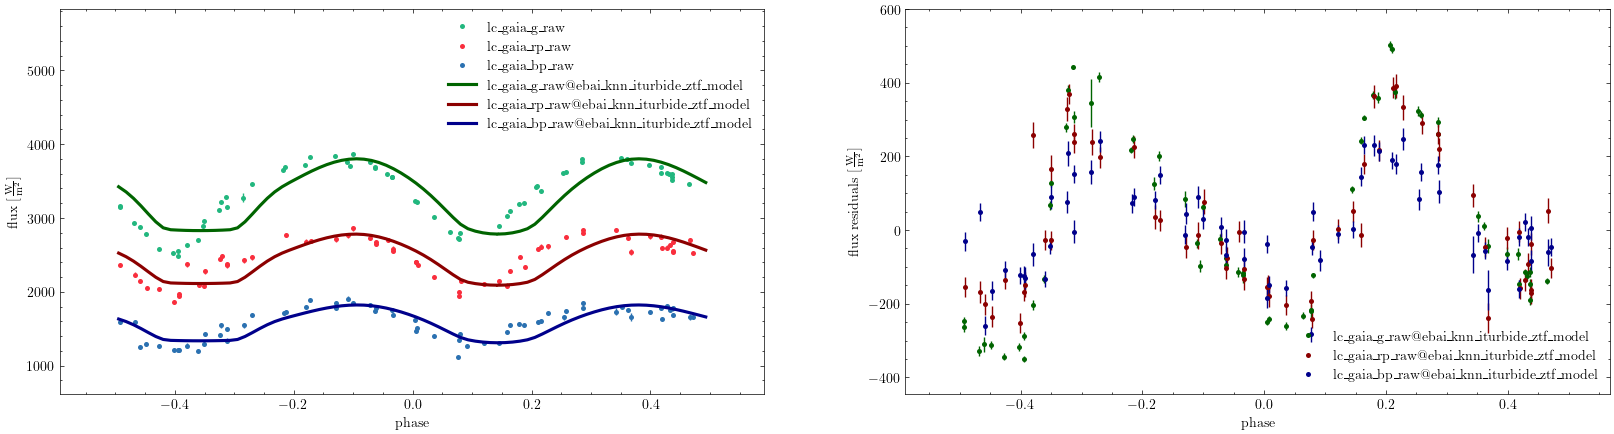

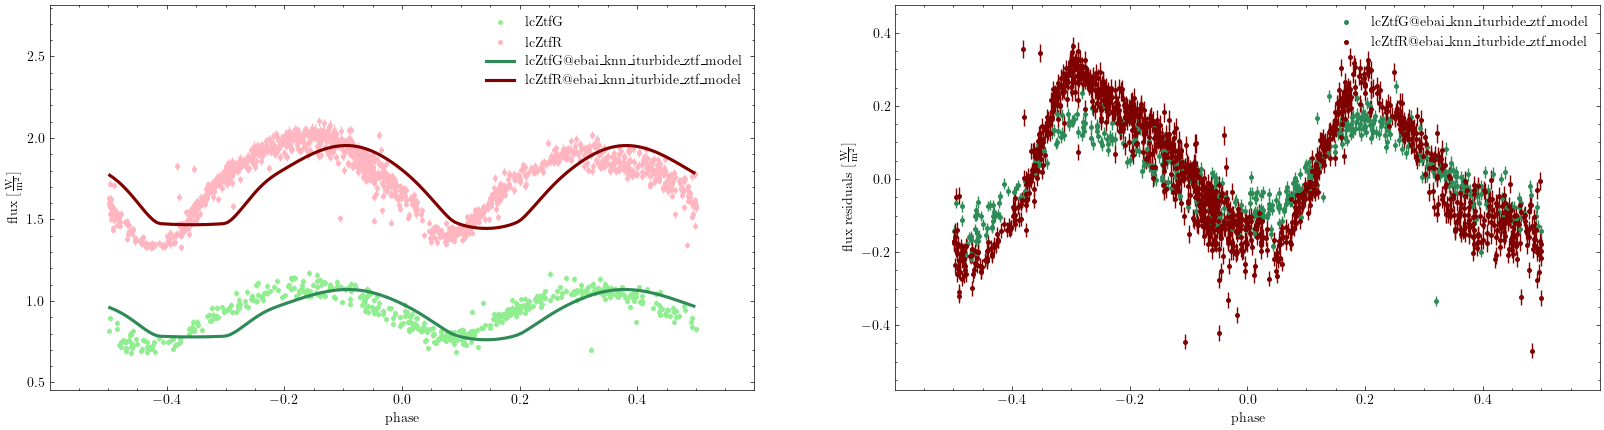

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

GridspecLayout(children=(HTML(value='<video width="800" height="600" controls autoplay loop>\n  <source type="…

ebai_knn_ztf_solution | ebai_knn_ztf_model
------------------------------------------------
Adopted:
t0_supconj@binary@orbit@component 0.03040 d 
teffratio@binary@orbit@component 0.99635  
incl@binary@orbit@component 1.27098 rad 
fillout_factor@contact_envelope@envelope@component 0.56954  
q@binary@orbit@component 5.44866  

Original values:
  t0_supconj@binary@orbit@component 0.00000 d 
  teffratio@binary@orbit@component 1.00000 
  incl@binary@orbit@component 90.00000 deg 
  fillout_factor@contact_envelope@envelope@component 0.64179 
  q@binary@orbit@component 1.00000 


100%|██████████| 407/407 [01:08<00:00,  5.97it/s]
Fri, 19 Jul 2024 14:44 BUNDLE       ERROR   Constraint 'requiv@secondary@star@constraint' raised the following error while attempting to solve for 'requiv@secondary@star@component'.  Consider flipping the constraint or changing the value of one of ['pot@contact_envelope@envelope@component', 'q@binary@orbit@component', 'sma@binary@orbit@component', 'requiv@secondary@star@component'] until the constraint succeeds.  Original error: potential > L1 critical value
Fri, 19 Jul 2024 14:44 BUNDLE       ERROR   Constraint 'requiv@primary@star@constraint' raised the following error while attempting to solve for 'requiv@primary@star@component'.  Consider flipping the constraint or changing the value of one of ['requiv@primary@star@component', 'q@binary@orbit@component', 'sma@binary@orbit@component', 'pot@contact_envelope@envelope@component'] until the constraint succeeds.  Original error: potential > L1 critical value


ebai_knn_ztf_model
	 Gaia (Raw) - 5018.668955228924
		 lc_gaia_g_raw - 3801.698569290854
		 lc_gaia_rp_raw - 592.4304709395527
		 lc_gaia_bp_raw - 624.5399149985167
------------------------------------------------
	 ZTF - 16074.779837853683
		 lcZtfG - 4674.758945940364
		 lcZtfR - 11400.020891913318


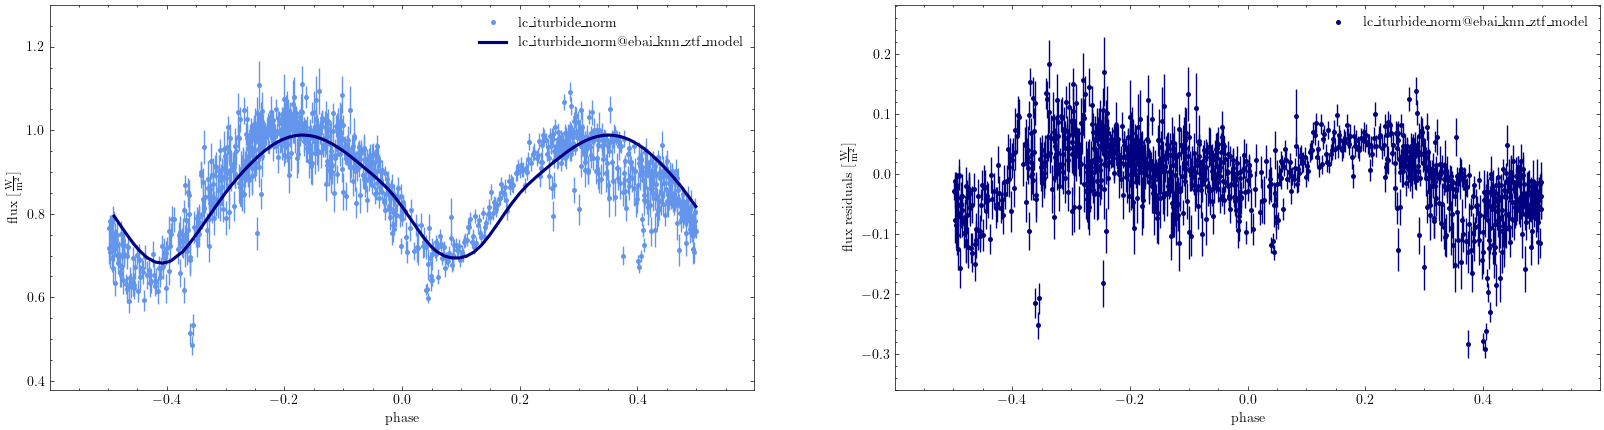

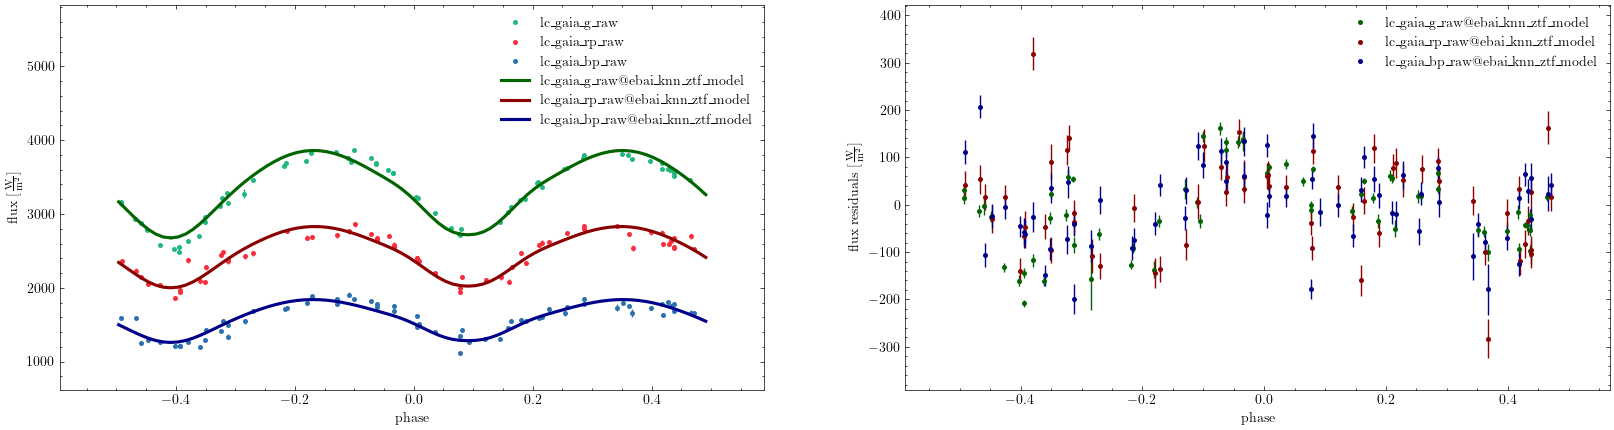

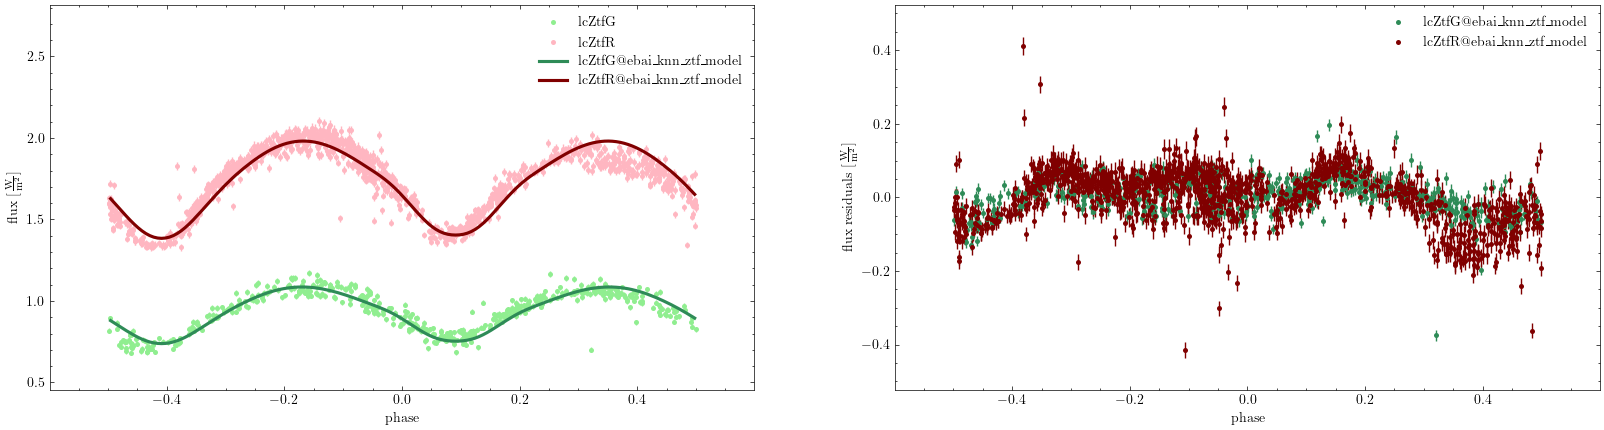

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

GridspecLayout(children=(HTML(value='<video width="800" height="600" controls autoplay loop>\n  <source type="…

ebai_knn_raw_gaia_solution | ebai_knn_raw_gaia_model
------------------------------------------------
Adopted:
t0_supconj@binary@orbit@component 0.02571 d 
teffratio@binary@orbit@component 0.98753  
incl@binary@orbit@component 1.25892 rad 
fillout_factor@contact_envelope@envelope@component 0.16514  
q@binary@orbit@component 2.46108  

Original values:
  t0_supconj@binary@orbit@component 0.00000 d 
  teffratio@binary@orbit@component 1.00000 
  incl@binary@orbit@component 90.00000 deg 
  fillout_factor@contact_envelope@envelope@component 0.64179 
  q@binary@orbit@component 1.00000 


100%|██████████| 407/407 [01:26<00:00,  4.68it/s]
Fri, 19 Jul 2024 14:48 BUNDLE       ERROR   Constraint 'requiv@secondary@star@constraint' raised the following error while attempting to solve for 'requiv@secondary@star@component'.  Consider flipping the constraint or changing the value of one of ['pot@contact_envelope@envelope@component', 'q@binary@orbit@component', 'sma@binary@orbit@component', 'requiv@secondary@star@component'] until the constraint succeeds.  Original error: potential > L1 critical value
Fri, 19 Jul 2024 14:48 BUNDLE       ERROR   Constraint 'requiv@primary@star@constraint' raised the following error while attempting to solve for 'requiv@primary@star@component'.  Consider flipping the constraint or changing the value of one of ['requiv@primary@star@component', 'q@binary@orbit@component', 'sma@binary@orbit@component', 'pot@contact_envelope@envelope@component'] until the constraint succeeds.  Original error: potential > L1 critical value


ebai_knn_raw_gaia_model
	 Gaia (Raw) - 13330.472606148383
		 lc_gaia_g_raw - 11354.682582929734
		 lc_gaia_rp_raw - 974.485632815219
		 lc_gaia_bp_raw - 1001.3043904034308
------------------------------------------------
	 ZTF - 15755.284512256521
		 lcZtfG - 5235.519953750905
		 lcZtfR - 10519.764558505616


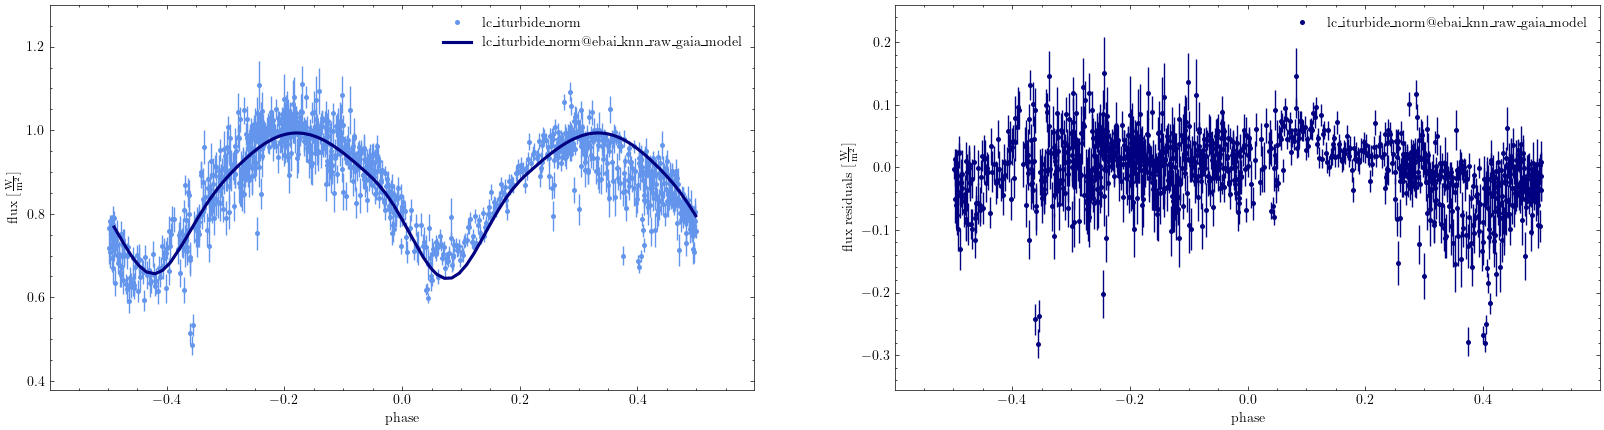

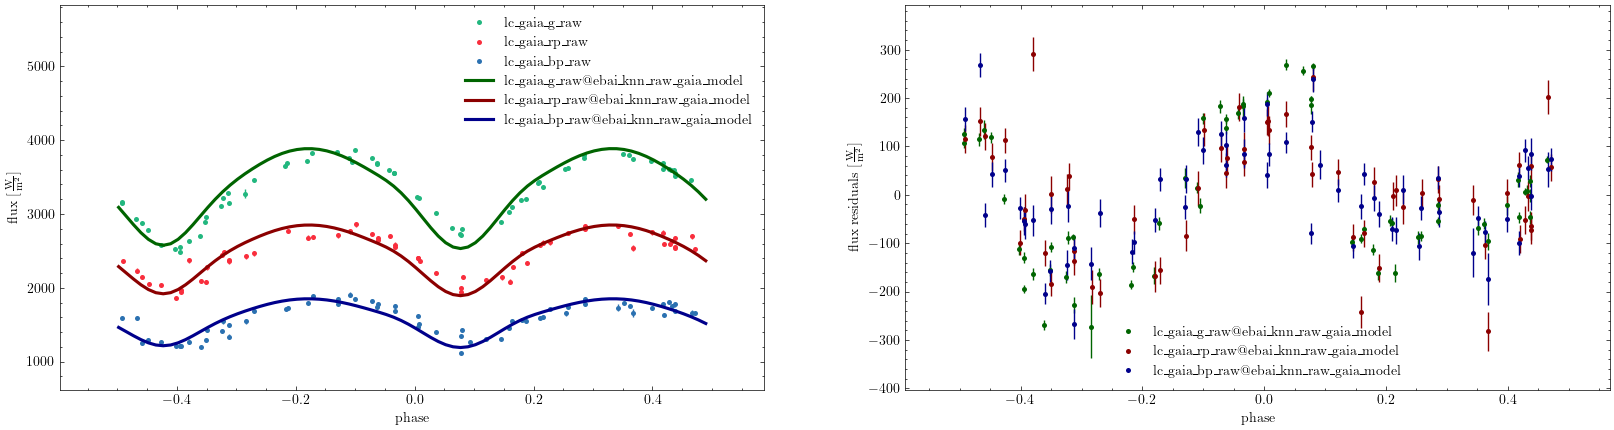

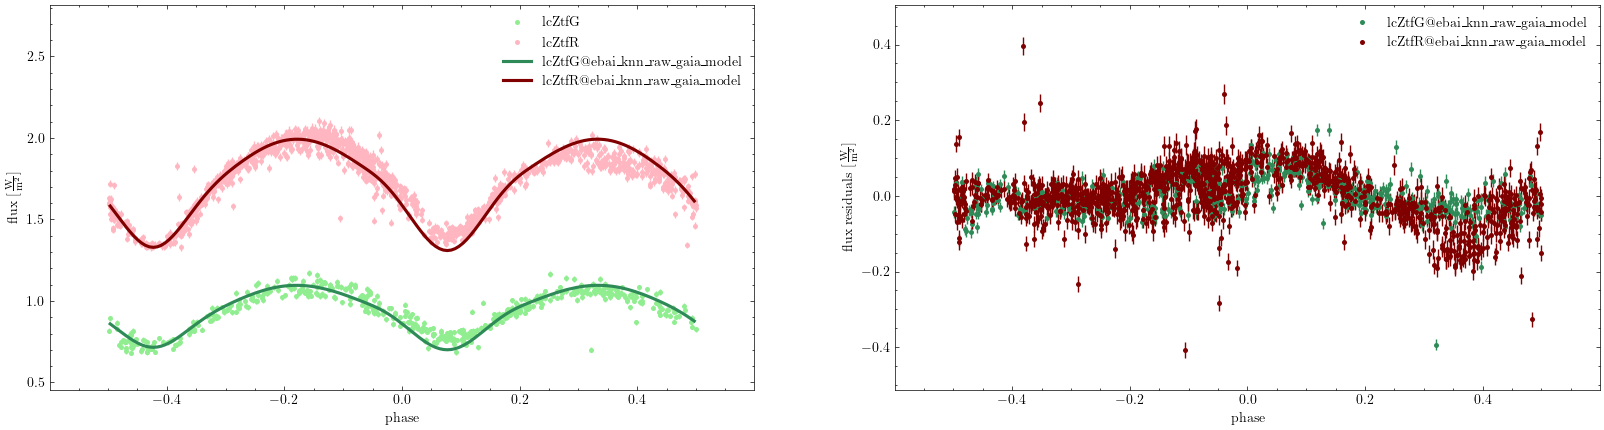

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

GridspecLayout(children=(HTML(value='<video width="800" height="600" controls autoplay loop>\n  <source type="…

In [26]:
PLOT_MODELS = True
ANIMATE = True
SAVE_BINARY_ANIMATION = False
logger.setLevel('WARNING')

def checkEstimators(solvers: list[str]): 
	for solver in solvers:
		solution = f"{solver}_solution"
		model = f"{solver}_model"
	
		# skipping any failed solvers
		if solution not in b.solutions:
			print("================================================")
			print(f"{solution} not found")
			print("================================================")
			continue
	
		print(solution, "|", model)
		print("------------------------------------------------")
	
		try:
			gen_utils.adopt_solution(b, solution, model_name=model, reset_params=True, run_compute=not model in b.models)
			# gen_utils.adopt_solution(b, solution, model_name=model, reset_params=True, run_compute=True)
		except Exception as e:
			print("=====================================")
			print(f"Failed to adopt {solution}", e, sep='\n')
			print("=====================================")
			b.remove_model(model)
			continue
		
		# printChi2(b, model)
		gen_utils.printChi2(b, model)
	
		if PLOT_MODELS:
			plotDatasetGroups = [['lc_iturbide_norm'], rawGaiaDatasets, ztfDatasets]
			gen_utils.plotModelResidualsFigsize(b, figsize=(20, 5), datasetGroups=plotDatasetGroups, model=model)
	
			if ANIMATE:
				gen_utils.displayAnims(1, 3, 
						gen_utils.genAnimatedMesh(b, logger, model=model, draw_title=True, title=model, save=f"./graphs/iturbide-gaia-ztf-final/anims/{solver}.gif" if SAVE_BINARY_ANIMATION else None),
						gen_utils.genAnimatedMesh(b, logger, model=model, component='primary', draw_title=True, title=f"{model} - Primary"),
						gen_utils.genAnimatedMesh(b, logger, model=model, component='secondary', draw_title=True, title=f"{model} - Secondary"))

if len(b.get_parameter(qualifier='ecc', context='component').constrained_by) != 0:
	b.flip_constraint(qualifier='ecc', solve_for='ecosw')
	b.flip_constraint(qualifier='per0', solve_for='esinw')
checkEstimators(['lcgeom_twogauss', 'lcgeom_polyfit'])

# necessary for EBAI estimators
if len(b.get_parameter(qualifier='ecosw', context='component').constrained_by) != 0:
	b.flip_constraint('ecosw', solve_for='ecc')
	b.flip_constraint('esinw', solve_for='per0')
checkEstimators([s for s in b.solvers if f'ebai_{ebaiMethod}' in s])

<>:34: SyntaxWarning: invalid escape sequence '\l'
<>:34: SyntaxWarning: invalid escape sequence '\l'
/tmp/ipykernel_545957/1597905886.py:34: SyntaxWarning: invalid escape sequence '\l'
  plt.title("EBAI Estimates $\lambda$")


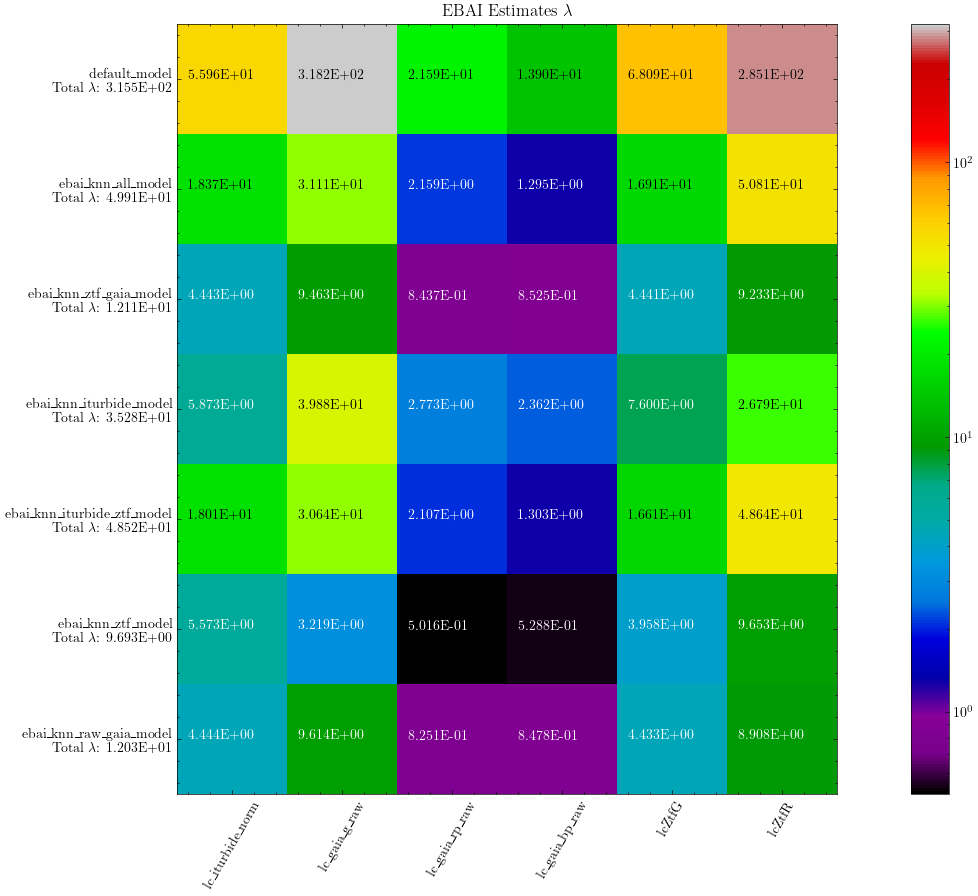

In [27]:
from matplotlib.colors import LogNorm

# ebaiModels = [m for m in b.models if f'ebai_{ebaiMethod}' in m]
comparisonModels = b.models
datasets = [d for d in b.datasets if 'mesh' not in d]
totalNumObservations = 0
for d in datasets:
	totalNumObservations += len(b.get_value(qualifier='times', context='dataset', dataset=d))

modelsDatasetsMatrix = np.zeros(shape=(len(comparisonModels), len(datasets)))
lambdaCostMatrix = np.zeros(shape=(len(comparisonModels), len(datasets)))

for m_idx, model in enumerate(comparisonModels):
	for d_idx, dataset in enumerate(datasets):
		numObservations = len(b.get_value(qualifier='times', context='dataset', dataset=d))
		modelsDatasetsMatrix[m_idx, d_idx] = np.sum(b.calculate_chi2(model=model, dataset=dataset))
		lambdaCostMatrix[m_idx, d_idx] = modelsDatasetsMatrix[m_idx, d_idx] / numObservations # cost normalization from PHOEBE reference ch. 6.1

plt.figure(figsize=(19, 10))
plt.imshow(lambdaCostMatrix, norm=LogNorm(), cmap='nipy_spectral')
for m_idx in range(len(comparisonModels)):
	for d_idx, d in enumerate(datasets):
		lambdaCost = lambdaCostMatrix[m_idx, d_idx]
		plt.text(d_idx - 0.4, m_idx, '%.3E' % lambdaCost, color='black' if lambdaCost > 10 else 'white')

plt.xticks(np.arange(len(datasets), dtype=int), datasets, rotation=60)

yticks = []
for m_idx, model in enumerate(comparisonModels):
	# yticks.append(f"{model}\nTotal $\\chi^2$: %.3E" % np.sum(modelsDatasetsMatrix[m_idx, :]))
	yticks.append(f"{model}\nTotal $\\lambda$: %.3E" % (np.sum(modelsDatasetsMatrix[m_idx, :])/totalNumObservations))
plt.yticks(np.arange(len(comparisonModels), dtype=int), yticks)
# plt.title("EBAI Estimates $\chi^2$")
plt.title("EBAI Estimates $\lambda$")
plt.colorbar()

In [28]:
for s in b.solutions:
	if f'ebai_{ebaiMethod}' in s:
		solverName = s.replace("_solution", "").replace("_norm", "")
		print(f"{s} | {b.calculate_chi2(model=solverName + '_model', dataset=rawGaiaDatasets + ztfDatasets + ['lc_iturbide_norm']):.3e}", 
		"-------------------------------------------", sep='\n')
		gen_utils.printFittedVals(b, s)
		print("Datasets:", b[f'value@{solverName}@lc_datasets'])
		print()

ebai_knn_all_solution | 1.425e+05
-------------------------------------------
t0_supconj@binary@orbit@component -0.11906 d 
teffratio@binary@orbit@component 0.94282  
incl@binary@orbit@component 1.50888 rad 
fillout_factor@contact_envelope@envelope@component 0.64545  
q@binary@orbit@component 9.06676  
Datasets: ['lc_iturbide_norm', 'lc_gaia_g_raw', 'lc_gaia_rp_raw', 'lc_gaia_bp_raw', 'lcZtfG', 'lcZtfR']

ebai_knn_ztf_gaia_solution | 3.458e+04
-------------------------------------------
t0_supconj@binary@orbit@component 0.02571 d 
teffratio@binary@orbit@component 0.98746  
incl@binary@orbit@component 1.22731 rad 
fillout_factor@contact_envelope@envelope@component 0.25767  
q@binary@orbit@component 1.93380  
Datasets: ['lc_gaia_g_raw', 'lc_gaia_rp_raw', 'lc_gaia_bp_raw', 'lcZtfG', 'lcZtfR']

ebai_knn_iturbide_solution | 1.007e+05
-------------------------------------------
t0_supconj@binary@orbit@component 0.01491 d 
teffratio@binary@orbit@component 0.99739  
incl@binary@orbit@component

In [29]:
gen_utils.printFittedVals(b, solution=f'ebai_{ebaiMethod}_ztf_gaia_solution', units={'incl@binary@orbit@component': u.deg})
print()
gen_utils.printFittedTwigsConstraints(b, solution=f'ebai_{ebaiMethod}_ztf_gaia_solution', units={'incl@binary@orbit@component': u.deg})

t0_supconj@binary@orbit@component 0.02571 d 
teffratio@binary@orbit@component 0.98746  
incl@binary@orbit@component 70.31953 deg 
fillout_factor@contact_envelope@envelope@component 0.25767  
q@binary@orbit@component 1.93380  

  t0_supconj@binary@orbit@component 0.00000 d 
  teffratio@binary@orbit@component 1.00000 
  incl@binary@orbit@component 90.00000 deg 
  fillout_factor@contact_envelope@envelope@component 0.64179 
  q@binary@orbit@component 1.00000 


In [30]:
b.adopt_solution(f'ebai_{ebaiMethod}_ztf_gaia_solution')
# b.adopt_solution(chosenSolution)

<ParameterSet: 38 parameters | contexts: dataset, component>

# Save estimator bundle

In [31]:
# gen_utils.saveBundle(b, "ebai-estimates")
# gen_utils.saveBundle(b, "ebai-estimates", "comp-LID3")
# gen_utils.saveBundle(b, "ebai-solver-runs-no-estimates")
# gen_utils.saveBundle(b, bundleName="ebai-estimates", subfolder="aviles-iturbide-gaia-ztf-relative_norm")
# gen_utils.saveBundle(b, bundleName="ebai-estimates", subfolder="clean-iturbide-gaia-ztf")
gen_utils.saveBundle(b, bundleName="ebai-estimates", subfolder="updated-data")

Fri, 19 Jul 2024 14:50 PARAMETERS   WARNING for faster compact saving, install ujson


'bundle-saves/updated-data/ebai-estimates.json.gz'

# Trimming Bundle

Dropping unused datasets, as well as cleaning up models that won't be used in future steps

In [32]:
# removing unused models (all of them until now)
b.remove_model(b.models)

<ParameterSet: 1631 parameters | contexts: model, figure>

In [33]:
# gen_utils.saveBundle(b, 'ebai-estimates-trimmed')
# gen_utils.saveBundle(b, 'ebai-estimates-trimmed', "comp-LID3")
gen_utils.saveBundle(b, bundleName="ebai-estimates-trimmed", subfolder="updated-data")

Fri, 19 Jul 2024 14:51 PARAMETERS   WARNING for faster compact saving, install ujson


'bundle-saves/updated-data/ebai-estimates-trimmed.json.gz'